Download all necessary data

In [87]:
!kaggle datasets download -d hasyimabdillah/workoutexercises-images
!unzip workoutexercises-images.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/pull up/pull up_700211.jpg  
  inflating: dataset/pull up/pull up_700221.jpg  
  inflating: dataset/pull up/pull up_700231.jpg  
  inflating: dataset/pull up/pull up_700241.jpg  
  inflating: dataset/pull up/pull up_700251.jpg  
  inflating: dataset/pull up/pull up_700261.jpg  
  inflating: dataset/pull up/pull up_800001.jpg  
  inflating: dataset/pull up/pull up_800011.jpg  
  inflating: dataset/pull up/pull up_800021.jpg  
  inflating: dataset/pull up/pull up_800031.jpg  
  inflating: dataset/pull up/pull up_800041.jpg  
  inflating: dataset/pull up/pull up_800051.jpg  
  inflating: dataset/pull up/pull up_800061.jpg  
  inflating: dataset/pull up/pull up_800071.jpg  
  inflating: dataset/pull up/pull up_800081.jpg  
  inflating: dataset/pull up/pull up_800091.jpg  
  inflating: dataset/pull up/pull up_800101.jpg  
  inflating: dataset/pull up/pull up_800111.jpg  
  inflating: dataset/pull up/pull up_800121.jpg  

Preprocessing Step

In [14]:
!pip install imutils
!pip install requests
!pip install torch torchvision --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [88]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import shutil
from imutils import paths
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
data_dir = Path("/content/dataset")  # Update to match dataset structure
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

# Ensure dataset directories exist
def check_directories():
    if not data_dir.exists():
        raise FileNotFoundError(f"Dataset directory {data_dir} not found. Ensure dataset is correctly placed.")

In [89]:
# Define transformations
def get_transforms():
    return {
        "train": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

# Prepare dataset
def prepare_dataset():
    if not train_dir.exists():
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        image_paths = list(paths.list_images(data_dir))
        train_paths, rest_paths = train_test_split(image_paths, test_size=0.3, stratify=[Path(p).parent.name for p in image_paths], random_state=42)
        val_paths, test_paths = train_test_split(rest_paths, test_size=0.5, stratify=[Path(p).parent.name for p in rest_paths], random_state=42)

        for path_list, folder in zip([train_paths, val_paths, test_paths], [train_dir, val_dir, test_dir]):
            for img_path in path_list:
                label = Path(img_path).parent.name
                label_dir = folder / label
                label_dir.mkdir(parents=True, exist_ok=True)
                shutil.copy(img_path, label_dir / Path(img_path).name)


In [90]:
# Load datasets
def load_datasets():
    transforms_dict = get_transforms()
    print(train_dir)
    return {
        "train": datasets.ImageFolder(train_dir, transform=transforms_dict["train"]),
        "val": datasets.ImageFolder(val_dir, transform=transforms_dict["val"]),
        "test": datasets.ImageFolder(test_dir, transform=transforms_dict["val"])
    }


In [91]:
# Create DataLoaders
def get_dataloaders(datasets_dict):
    return {
        "train": DataLoader(datasets_dict["train"], batch_size=16, shuffle=True, num_workers=4),
        "val": DataLoader(datasets_dict["val"], batch_size=16, shuffle=False, num_workers=4),
        "test": DataLoader(datasets_dict["test"], batch_size=16, shuffle=False, num_workers=4)
    }

Preprocessing

In [94]:
check_directories()
prepare_dataset()
datasets_dict = load_datasets()
dataloaders = get_dataloaders(datasets_dict)

/content/dataset/train


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [95]:
# Load EfficientNet model
def get_model():
    model = models.resnet50(pretrained=True)
    # num_ftrs = model.classifier[1].in_features
    num_ftrs = model.fc.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, len(os.listdir(train_dir))),
        nn.LogSoftmax(dim=1)
    )
    return model.to(device)

In [96]:
# Train model
def train_model(model, criterion, optimizer, dataloaders, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloaders["train"]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in dataloaders["val"]:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet.pth")

In [97]:
def classify_image_from_url(image_url, model):
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw).convert("RGB")
    transform = get_transforms()["val"]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    class_names = sorted(os.listdir(train_dir))
    predicted_label = class_names[predicted_class]

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

Train Model

In [98]:
model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
train_model(model, criterion, optimizer, dataloaders, epochs=5)
# model.load_state_dict(torch.load("best_efficientnet.pth", map_location=device))
# model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 | Train Loss: 0.8683 | Train Acc: 75.86% | Val Acc: 87.09%
Epoch 2/5 | Train Loss: 0.3436 | Train Acc: 90.20% | Val Acc: 95.36%
Epoch 3/5 | Train Loss: 0.2526 | Train Acc: 92.66% | Val Acc: 91.79%
Epoch 4/5 | Train Loss: 0.1903 | Train Acc: 94.52% | Val Acc: 96.07%
Epoch 5/5 | Train Loss: 0.1896 | Train Acc: 94.48% | Val Acc: 96.63%


Classifying on google Images

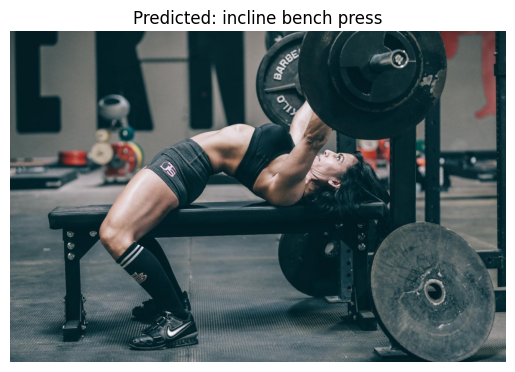

'incline bench press'

In [99]:
image_url = 'https://i0.wp.com/womenwholiftweights.com/wp-content/uploads/2016/12/WomanBenchPress.jpg?fit=1518%2C1012&ssl=1'
classify_image_from_url(image_url, model)

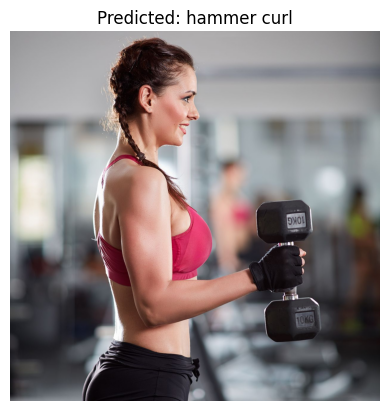

'hammer curl'

In [100]:
image_url = 'https://www.shape.com/thmb/zM_afeI7D3spw4da9OqU4-KDGR0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/hammer-curls-form-5c6c9cfb28f34c8e97cd64812156a9d1.jpg'
classify_image_from_url(image_url, model)

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


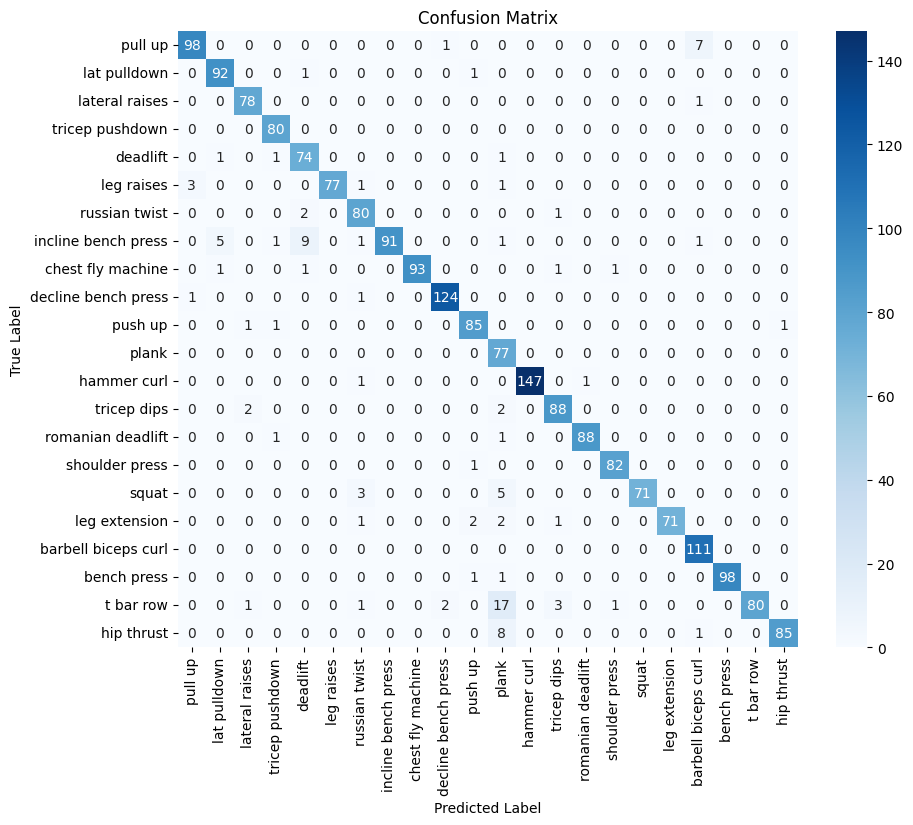

In [35]:
evaluate_model(model, dataloaders['val'])

In [92]:
import cv2
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
image_paths = list(paths.list_images('/content/dataset'))
hashes = {}

# loop over our image paths
for image_path in image_paths:
	# load the input image and compute the hash
	image = cv2.imread(image_path)
	h = dhash(image)

	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	p = hashes.get(h, [])
	p.append(image_path)
	hashes[h] = p

[INFO] computing image hashes...


In [93]:
import numpy as np
args = {
	"dataset": "/content/dataset",
	"remove": 1
}

# loop over the image hashes
for (h, hashed_paths) in hashes.items():
	# check to see if there is more than one image with the same hash
	if len(hashed_paths) > 1:
		# check to see if this is a dry run
		if args["remove"] <= 0:
			# initialize a montage to store all images with the same
			# hash
			montage = None

			# loop over all image paths with the same hash
			for p in hashed_paths:
				# load the input image and resize it to a fixed width
				# and heightG
				image = cv2.imread(p)
				image = cv2.resize(image, (150, 150))

				# if our montage is None, initialize it
				if montage is None:
					montage = image

				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])

			# show the montage for the hash
			print("[INFO] hash: {}".format(h))
			plt_imshow("Montage", montage)

        # otherwise, we'll be removing the duplicate images
		else:
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
			for p in hashed_paths[1:]:
				os.remove(p)